In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (150,150)

In [ ]:
# load data function that loads images and labels from the Train and Test folders

def load_data():

    datasets = ['/content/drive/MyDrive/Colab Notebooks/Blood Cell Classification/dataset2-master/images/TRAIN','/content/drive/MyDrive/Colab Notebooks/Blood Cell Classification/dataset2-master/images/TEST' ]
    images = []
    labels = []

    # iterate through training and test sets
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [ ]:
# Train and test sets were combined due to feedback on other Kaggle notebooks suggesting that poor shuffling led to poor results and overfitting to the validation set 

images, labels = load_data()

100%|██████████| 620/620 [03:28<00:00,  2.98it/s]


In [ ]:
# Shuffle and split data into Training (80%), Validation (10%), Test (10%) sets

images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)


In [ ]:
# Explore dataset. How many training, validation and testing examples do we have ?
# What is the size and shape of the images and labels ? What is the proportion of each observed category ?

n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))


Number of training examples: 9955
Number of validation examples: 1245
Number of testing examples: 1244
Training images are of shape: (9955, 150, 150, 3)
Training labels are of shape: (9955,)
Validation images are of shape: (1245, 150, 150, 3)
Validation labels are of shape: (1245,)
Test images are of shape: (1244, 150, 150, 3)
Test labels are of shape: (1244,)


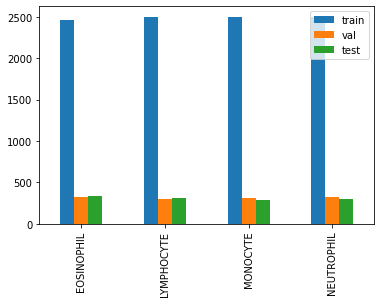

In [ ]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

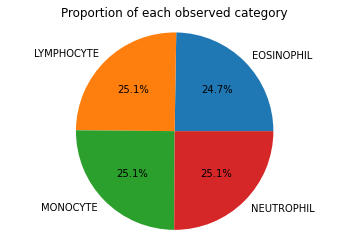

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
# Normalise the data 

train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

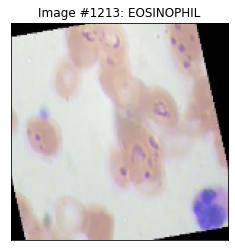

In [ ]:
# visualise the data by displaying a random image from the training set 

def display_random_image (class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)
    

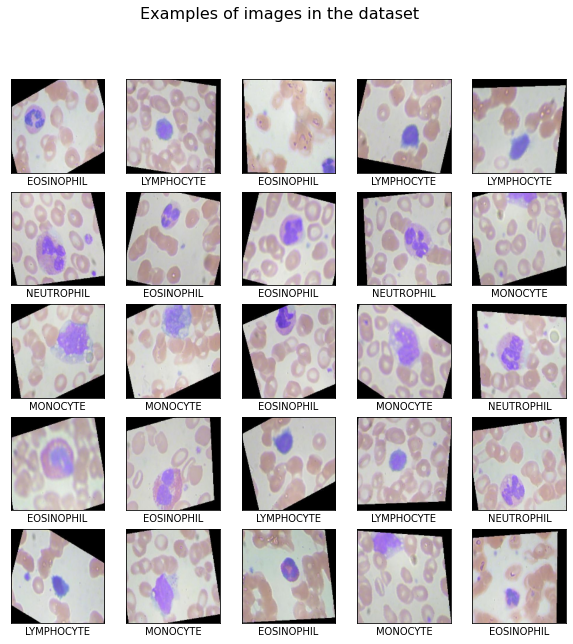

In [ ]:
# display first 25 images from training with corresponding labels 

def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

In [ ]:
### Model number 1: Custom Built CNN Model 

model1 = Sequential()

# First Conv block
model1.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model1.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv block
model1.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Third Conv block
model1.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Forth Conv block
model1.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))

# Fifth Conv block 
model1.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))

# FC layer 
model1.add(Flatten())
model1.add(Dense(units = 512 , activation = 'relu'))
model1.add(Dropout(0.7))
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(units = 64 , activation = 'relu'))
model1.add(Dropout(0.3))

# Output layer
model1.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model1.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model1.summary()

# Implement callbacks 
checkpoint = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

# Train
history1 = model1.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 10, 
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0

In [ ]:
# Create Accuracy and Loss chart function

def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(10)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

In [ ]:
# Show accuracy loss chart 

plot_accuracy_loss_chart(history1)

In [ ]:
# Evaluating the model on the test data

results = model1.evaluate(test_images, test_labels)

print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

39/39 [==============================] - 17s 427ms/step - loss: 0.1705 - accuracy: 0.9405
Loss of the model is -  0.17047205567359924
Accuracy of the model is -  94.05144453048706 %


In [ ]:
model1.save('Bloodcell_Classification_Model1_Custom_Build_10_epochs.h5')

In [ ]:
predictions = model1.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([0, 1, 3, 3, 0, 0, 2, 3, 2, 0, 1, 3, 0, 3, 1])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.94      0.85      0.89       338
LYMPHOCYTE (Class 1)       1.00      1.00      1.00       308
  MONOCYTE (Class 2)       1.00      0.99      0.99       293
NEUTROPHIL (Class 3)       0.84      0.94      0.89       305

            accuracy                           0.94      1244
           macro avg       0.94      0.94      0.94      1244
        weighted avg       0.94      0.94      0.94      1244



In [ ]:
# Create confusion matrix

cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

array([[286,   0,   0,  52],
       [  1, 307,   0,   0],
       [  0,   0, 290,   3],
       [ 18,   0,   0, 287]])

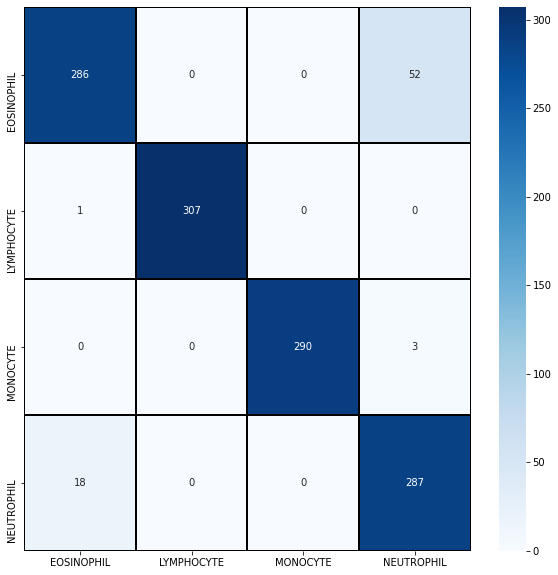

In [ ]:
# Confusion matrix plot function and execute 

def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

In [ ]:
### Model number 2: Fine tuned Densenet201 model 

# Copy Densenet201 model and remove fully connected layers 

densenet_model = DenseNet201(
    include_top = False,
    weights = 'imagenet', 
    input_tensor = None, 
    input_shape = (150,150,3), 
    pooling = None
)

# Option here to train on the final Conv5 block in the densenet model ("True") or use imagenet weights for this layer ("False")

densenet_model.trainable = True

for layer in densenet_model.layers:
  if 'conv5' in layer.name:
    layer.trainable = False
  else:
    layer.trainable = False

# 3 fully connected layers are added, with 256, 128 and 64 units respectively
# Dropout and Batch Normalization are performed on the fully connected layers.

input = Input(shape = (150,150,3))
layer = densenet_model(inputs=input)
layer = Flatten()(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=256, activation='relu')(layer)
layer = Dropout(0.7)(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=128, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=64, activation='relu')(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=4,activation='softmax')(layer)

model2 = Model(inputs=input, outputs=layer)

model2.summary()

model2.compile(loss='sparse_categorical_crossentropy',
            optimizer= 'adam',
            metrics=['accuracy'])


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten_3 (Flatten)          (None, 30720)             0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 30720)             122880    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               7864576   
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024

In [ ]:
# Train model 

history2 = model2.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 10, 
    validation_data =(val_images, val_labels) , 
    callbacks=[learning_rate_reduction])

Epoch 1/10
312/312 [==============================] - 1040s 3s/step - loss: 1.5520 - accuracy: 0.3122 - val_loss: 1.1093 - val_accuracy: 0.5695
Epoch 2/10
312/312 [==============================] - 1016s 3s/step - loss: 1.1443 - accuracy: 0.4783 - val_loss: 0.7947 - val_accuracy: 0.6707
Epoch 3/10
312/312 [==============================] - 1015s 3s/step - loss: 0.9401 - accuracy: 0.5892 - val_loss: 0.6293 - val_accuracy: 0.7365
Epoch 4/10
312/312 [==============================] - 1024s 3s/step - loss: 0.8148 - accuracy: 0.6654 - val_loss: 0.5744 - val_accuracy: 0.7598
Epoch 5/10
312/312 [==============================] - 1018s 3s/step - loss: 0.7618 - accuracy: 0.6907 - val_loss: 0.4903 - val_accuracy: 0.7896
Epoch 6/10
312/312 [==============================] - 1018s 3s/step - loss: 0.6681 - accuracy: 0.7391 - val_loss: 0.4544 - val_accuracy: 0.8120
Epoch 7/10
312/312 [==============================] - 1018s 3s/step - loss: 0.6115 - accuracy: 0.7640 - val_loss: 0.3954 - val_accuracy:

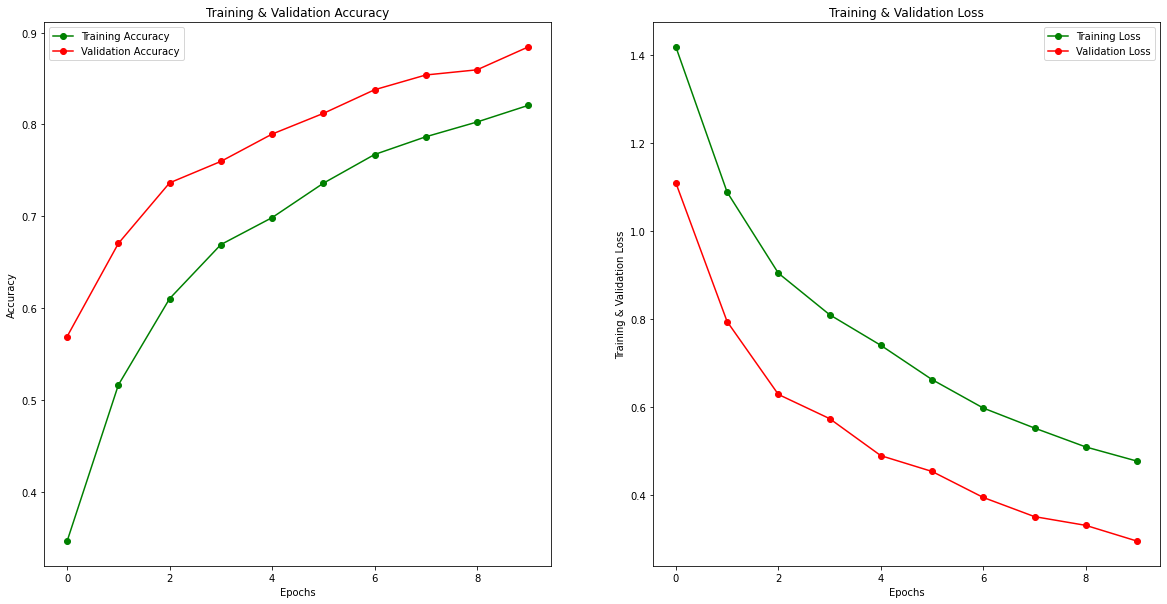

In [ ]:
# Accuracy and Loss charts for Model 2

plot_accuracy_loss_chart(history2)

In [ ]:
# Save model 

model2.save("bloodcell_densenet201_10epochs_lrreduction.h5")

In [ ]:
# Evaluating the model on the test data

results = model2.evaluate(test_images, test_labels)

print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

39/39 [==============================] - 111s 3s/step - loss: 0.2921 - accuracy: 0.8907
Loss of the model is -  0.2921276390552521
Accuracy of the model is -  89.06752467155457 %


In [ ]:
# Create predictions for test images

predictions2 = model2.predict(test_images)
predictions2 = np.argmax(predictions2,axis=1)
predictions2[:15]

array([3, 1, 3, 3, 0, 0, 2, 3, 2, 0, 1, 3, 0, 0, 1])

In [ ]:
print(classification_report(
    test_labels, 
    predictions2, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.87      0.79      0.82       338
LYMPHOCYTE (Class 1)       0.93      0.99      0.96       308
  MONOCYTE (Class 2)       0.93      0.99      0.96       293
NEUTROPHIL (Class 3)       0.83      0.82      0.82       305

            accuracy                           0.89      1244
           macro avg       0.89      0.89      0.89      1244
        weighted avg       0.89      0.89      0.89      1244



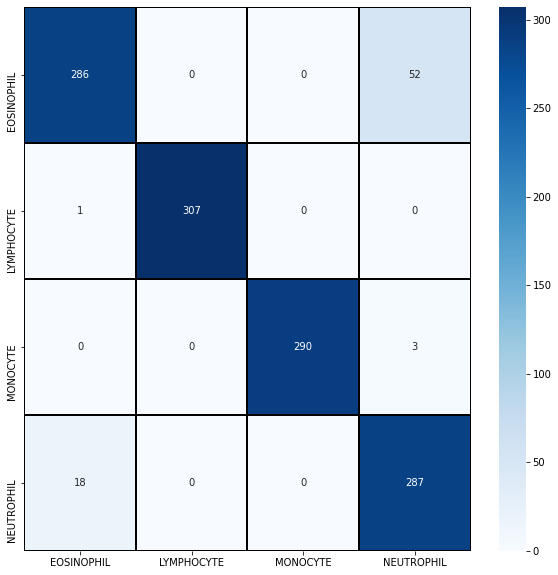

In [ ]:
# Plot confusion matrix for Model 2

cm2 = confusion_matrix(test_labels, predictions2)
cm2 = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
plot_confusion_matrix(cm2)


In [ ]:
### Model number 3: finetuned VGG16 model. 

from keras.applications import VGG16

vgg16_model = VGG16(
    include_top = False,
    weights = 'imagenet', 
    input_tensor = None, 
    input_shape = (150,150,3), 
    pooling = None
)

# 3 fully connected layers are added, with 256, 128 and 64 units respectively
# Dropout and Batch Normalization are performed on the full connected layers. 

vgg16_model.trainable = True

for layer in vgg16_model.layers:
  if 'block5' in layer.name:
    layer.trainable = False
  else:
    layer.trainable = False

input = Input(shape = (150,150,3))

layer = vgg16_model(inputs=input)
layer = Flatten()(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=256, activation='relu')(layer)
layer = Dropout(0.7)(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=128, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=64, activation='relu')(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=4,activation='softmax')(layer)

model3 = Model(inputs=input, outputs=layer)

model3.summary()

model3.compile(loss='sparse_categorical_crossentropy',
            optimizer= 'adam',
            metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
______________________________________________________________

In [ ]:
history3 = model3.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 10, 
    validation_data = (val_images, val_labels), 
    callbacks=[learning_rate_reduction])

Epoch 1/10
312/312 [==============================] - 2381s 8s/step - loss: 1.5564 - accuracy: 0.2912 - val_loss: 1.1843 - val_accuracy: 0.4940
Epoch 2/10
312/312 [==============================] - 2364s 8s/step - loss: 1.2399 - accuracy: 0.4311 - val_loss: 0.9421 - val_accuracy: 0.6161
Epoch 3/10
312/312 [==============================] - 2358s 8s/step - loss: 1.0339 - accuracy: 0.5481 - val_loss: 0.7417 - val_accuracy: 0.7004
Epoch 4/10
312/312 [==============================] - 2356s 8s/step - loss: 0.8776 - accuracy: 0.6409 - val_loss: 0.6484 - val_accuracy: 0.7679
Epoch 5/10
312/312 [==============================] - 2366s 8s/step - loss: 0.7634 - accuracy: 0.6982 - val_loss: 0.5944 - val_accuracy: 0.7839
Epoch 6/10
312/312 [==============================] - 2384s 8s/step - loss: 0.6878 - accuracy: 0.7367 - val_loss: 0.5329 - val_accuracy: 0.8112
Epoch 7/10
312/312 [==============================] - 2359s 8s/step - loss: 0.6274 - accuracy: 0.7597 - val_loss: 0.5376 - val_accuracy:

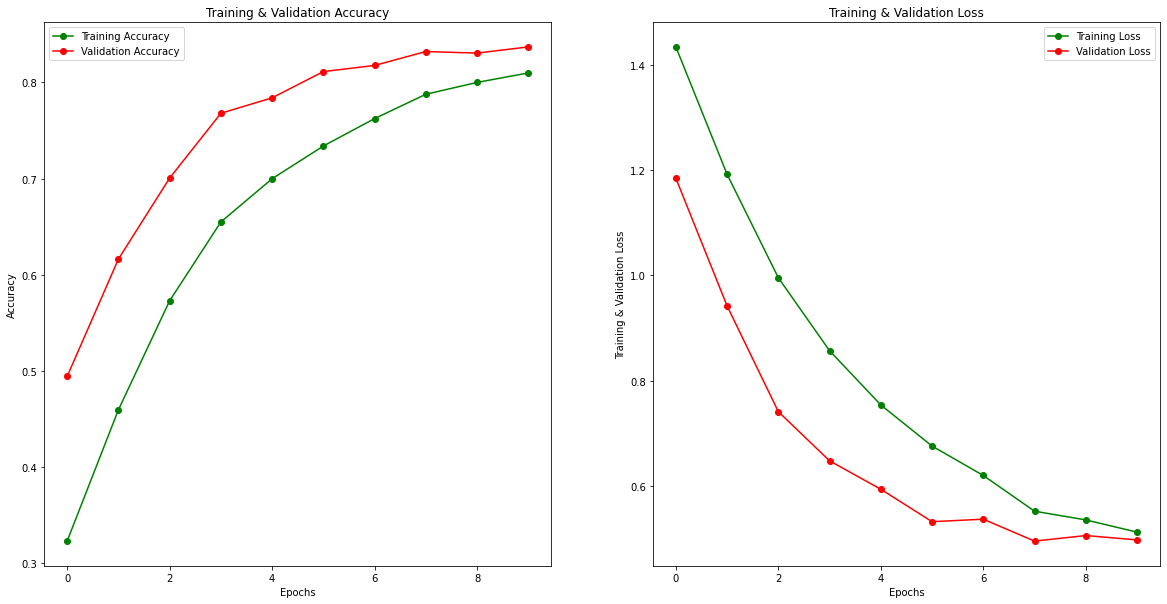

In [ ]:
plot_accuracy_loss_chart(history3)

In [ ]:
# Evaluating the model on the test data

results = model3.evaluate(test_images, test_labels)

print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

39/39 [==============================] - 264s 7s/step - loss: 0.4805 - accuracy: 0.8256
Loss of the model is -  0.48052993416786194
Accuracy of the model is -  82.55627155303955 %


In [ ]:
model3.save('Bloodcell_Classification_Model2_Finetuned_VGG16_10_epochs.h5')

In [ ]:
# Create predictions for test images

predictions3 = model3.predict(test_images)
predictions3 = np.argmax(predictions3,axis=1)
predictions3[:15]

array([3, 2, 2, 3, 3, 1, 2, 3, 1, 3, 0, 2, 3, 3, 3])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    test_labels, 
    predictions3, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.84      0.62      0.71       310
LYMPHOCYTE (Class 1)       0.83      0.91      0.87       315
  MONOCYTE (Class 2)       0.92      0.96      0.94       295
NEUTROPHIL (Class 3)       0.73      0.82      0.77       324

            accuracy                           0.83      1244
           macro avg       0.83      0.83      0.82      1244
        weighted avg       0.83      0.83      0.82      1244



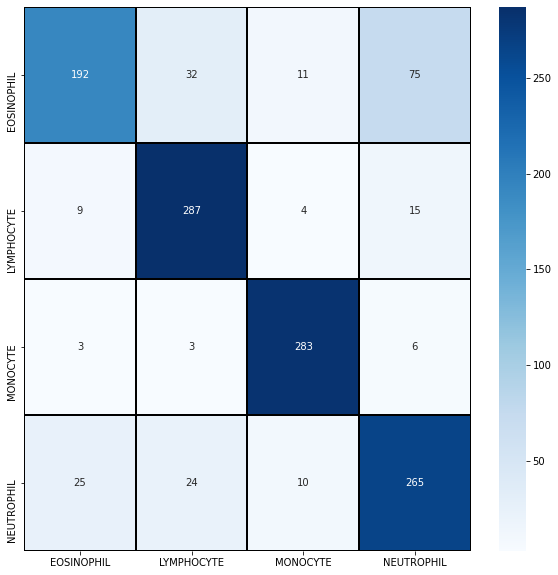

In [17]:
# Plot confusion matrix for Model 3

cm3 = confusion_matrix(test_labels, predictions3)
cm3 = pd.DataFrame(cm3, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])

def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm3)


In [ ]:
while True:
  pass